In [180]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_absolute_error

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [181]:
# Информация о выбросах
def outlines_info(column):
    # график
    plt.figure();
    sns.boxplot(column);
    plt.show();
    # выбросы
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    low_bound = q1 - (iqr * 1.5)
    up_bound = q3 + (iqr * 1.5)
    print(low_bound, up_bound)
    print("Процент значений за границей: {}%".format(len(column[((column > up_bound) | (column < low_bound))])* 100/len(column)))

In [182]:
# Граничные значения по колонке
def get_bounds(column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    low_bound = q1 - (iqr * 1.5)
    up_bound = q3 + (iqr * 1.5)
    return low_bound, up_bound

In [183]:
# Удаление выбросов
def remove_outlines(df, column):
    low_bound, up_bound = get_bounds(df[column])
    print(len(df))
    return df.loc[df[column].between(low_bound, up_bound)]

In [184]:
# Зафиксируем версию пакетов и random_seed, для воспроизводимости эксперимента
!pip freeze > requirements.txt
random_seed = 31


In [185]:
df_test = pd.read_csv("/kaggle/input/sf-dst-scoring/test.csv")
df_train = pd.read_csv("/kaggle/input/sf-dst-scoring/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Описание данных
```
client_id                идентификатор клиента
education                уровень образования
sex                      пол заёмщика
age                      возраст заёмщика
car                      флаг наличия автомобиля
car_type                 флаг автомобиля-иномарки
decline_app_cnt          количество отказанных прошлых заявок
good_work                флаг наличия «хорошей» работы
bki_request_cnt          количество запросов в БКИ
home_address             категоризатор домашнего адреса
work_address             категоризатор рабочего адреса
income                   доход заёмщика
foreign_passport         наличие загранпаспорта
sna                      связь заемщика с клиентами банка
first_time               давность наличия информации о заемщике
score_bki                скоринговый балл по данным из БКИ
region_rating            рейтинг региона
app_date                 дата подачи заявки
default                  наличие дефолта
```

Целевая переменная:

`default`

Признаки c пропусками:

`education`

Бинарные переменные:

```
sex
car
car_type
foreign_passport
good_work
```

Категориальные переменные:

```
education
work_address
home_address
sna
first_time
region_rating
app_date
```

Числовые переменные:
```
age
decline_app_cnt
income
bki_request_cnt
score_bki
```

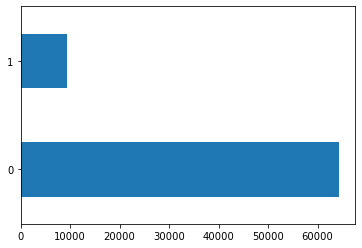

In [186]:
# Посмотрим выборку на сбалансированность

df_train.default.value_counts().plot.barh();

Клиентов без дефолта у банка значительно больше. Выборка несбалансированна, но мы можем попробовать это компенсировать с помощью гиперпараметра логистической регрессии `class_weight`

## 1. Предобработка данных

### Заполнение пропусков

In [187]:
# Посмотрим на столбец с пропусками

df_train.education.value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

Значений с пропусками мало, можем заполнить наиболее часто встречающимся значением 'SCH'

In [188]:
df_train.education.fillna('SCH',inplace=True)
df_test.education.fillna('SCH',inplace=True)

### Подготовка данных для обучения модели

Разделим столбцы по типам переменных

In [189]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

Признак `app_date` тоже категориальный, но преобразование с помощью OneHotEncoder обесценит информацию от него

In [190]:
num_cols.append("days")
# Преобразуем строку в datetime формат
df_train.app_date = pd.to_datetime(df_train.app_date, format='%d%b%Y')
# Создадим новый признак days, количество дней с первой даты в данных
min_date = df_train.app_date.min()
df_train['days'] = (df_train.app_date - min_date).dt.days.astype('int')
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,31
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,70
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,31
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,22
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0,62
73795,76821,2014-03-24,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0,82
73796,103695,2014-04-22,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0,111
73797,861,2014-01-04,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,3


In [191]:
# Аналогично для тестовой

df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')
min_date = df_test.app_date.min()
df_test['days'] = (df_test.app_date - min_date).dt.days.astype('int')
df_test

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,80
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,23
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,81
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,33
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,2014-03-31,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,89
36345,106254,2014-04-25,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,114
36346,81852,2014-03-30,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,88
36347,1971,2014-01-07,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,6


Посмотрим на распределение числовых переменных

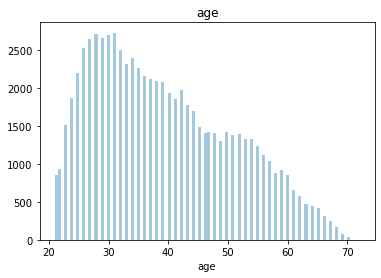

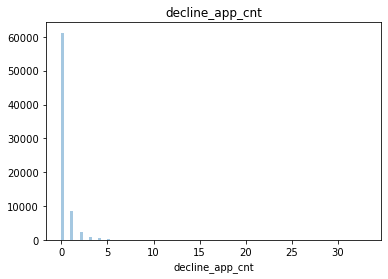

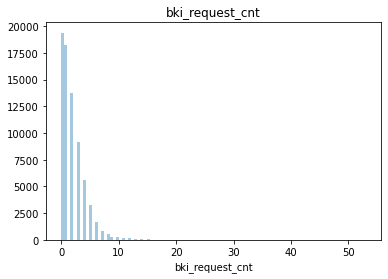

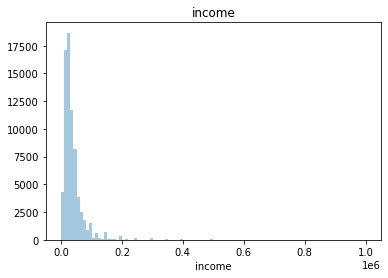

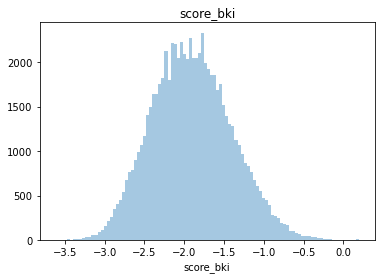

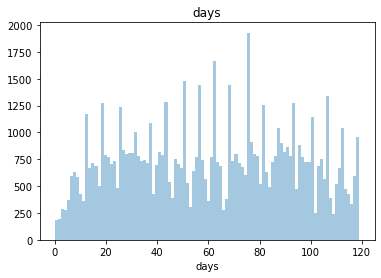

In [192]:
for i in num_cols:
    plt.figure()
    sns.distplot(df_train[i], kde = False, rug=False, bins = 100)
    plt.title(i)
    plt.show()

После построения гистограмм стало видно, что распределения числовых переменных `income`, `bki_request_count`, `decline_app_cnt`, `age` смещены влево от нормального распределения. Чтобы сделать распределение более нормальным, можно работать с логарифмированными величинами этих переменных. `score_bki` распределен нормально, поэтому преобразование не требуется.

In [193]:
df_train.income = np.log(df_train.income)
df_train.age = np.log(df_train.age)
df_train.bki_request_cnt = np.log(df_train.bki_request_cnt + 1) # +1 для предотвращения взятия логарифма от 0
df_train.decline_app_cnt = np.log(df_train.decline_app_cnt + 1)

### Выбросы

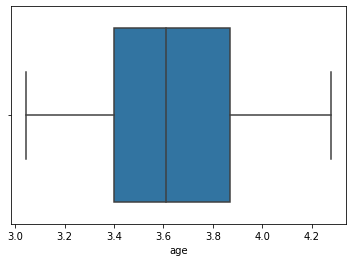

2.696191937793552 4.576206454776495
Процент значений за границей: 0.0%


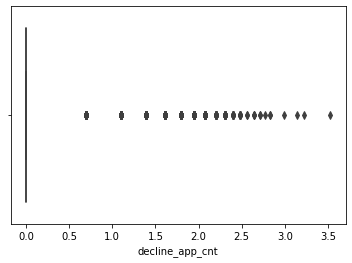

0.0 0.0
Процент значений за границей: 17.05307659995393%


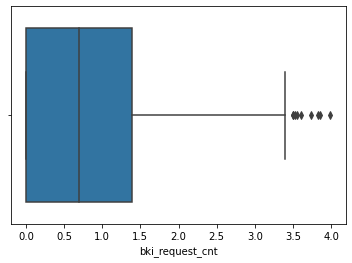

-2.0794415416798357 3.465735902799726
Процент значений за границей: 0.012195287199013537%


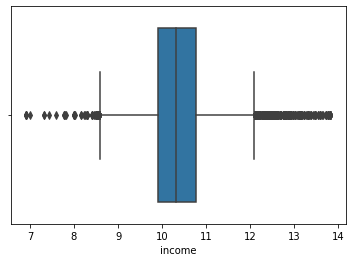

8.590284446505276 12.092159395920877
Процент значений за границей: 2.394341386739658%


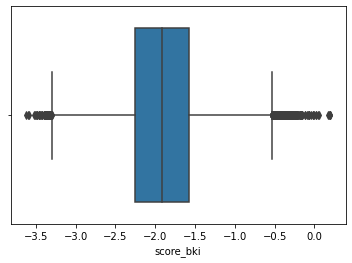

-3.2940876975 -0.5352773974999998
Процент значений за границей: 0.47561620076152794%


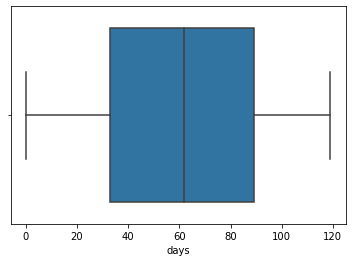

-51.0 173.0
Процент значений за границей: 0.0%


In [194]:
for column in num_cols:
    outlines_info(df_train[column]);

Очистим выбросы там, где их меньше 5% `score_bki`, `income` и `bki_request_cnt`

In [195]:
df_train = remove_outlines(df_train, "score_bki")
df_train = remove_outlines(df_train, "income")
df_train = remove_outlines(df_train, "bki_request_cnt")

73799
73448
71682


### Корреляция

Оценим корреляцию Пирсона для непрерывных переменных по формуле:

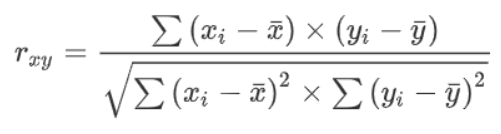

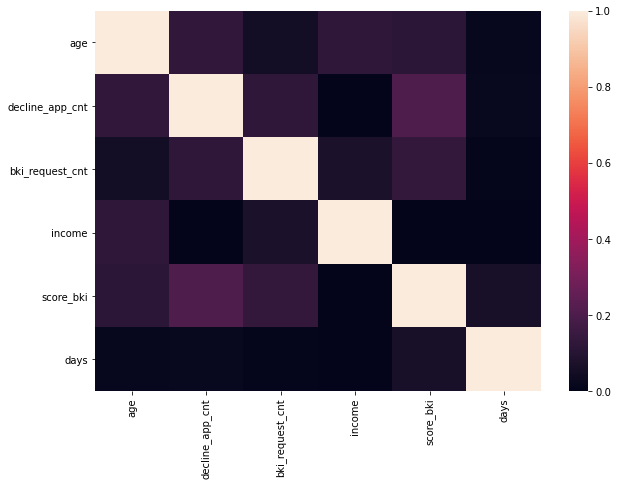

In [196]:
plt.subplots(figsize=(10, 7))
sns.heatmap(df_train[num_cols].corr().abs(), vmin=0, vmax=1);

Взаимосвязь пар числовых признаков по Пирсону слабая, поэтому убирать ничего не нужно

### Значимость числовых признаков

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

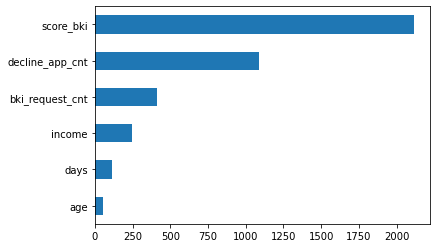

In [197]:
imp_num = Series(f_classif(df_train[num_cols], df_train.default)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Наименее важным признаком оказался возраст

In [198]:
# Преобразуем бинарные признаки с помощью LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,1,4.127134,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798127,4,1,0,0,31
1,63161,2014-03-12,SCH,0,4.077537,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852194,4,1,0,0,70
2,25887,2014-02-01,SCH,1,3.218876,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308953,1,4,1,0,31
3,16222,2014-01-23,SCH,0,3.970292,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210340,1,3,0,0,22
4,101655,2014-04-18,GRD,1,3.871201,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308953,1,4,1,0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,GRD,0,3.806662,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.740969,4,4,0,0,62
73795,76821,2014-03-24,SCH,1,3.713572,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156251,1,4,0,0,82
73796,103695,2014-04-22,SCH,1,3.433987,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714418,2,2,0,0,111
73797,861,2014-01-04,SCH,0,3.367296,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472705,2,3,0,1,3


In [199]:
for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])
df_test

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,80
1,17527,2014-01-24,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,23
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,81
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,33
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,2014-03-31,SCH,0,37,0,0,1,0,-1.744976,3,50,2,3,15000,4,1,0,89
36345,106254,2014-04-25,GRD,0,64,1,1,0,0,-2.293781,3,60,1,2,200000,1,4,0,114
36346,81852,2014-03-30,GRD,1,31,0,0,2,0,-0.940752,1,50,1,2,60000,4,2,0,88
36347,1971,2014-01-07,UGR,0,27,0,0,1,0,-1.242392,2,80,2,3,30000,1,1,0,6


In [200]:
# Преобразуем категориальные признаки с помощью OneHotEncoder

X_cat = OneHotEncoder(sparse = False).fit_transform(df_train[cat_cols].values)
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,1,4.127134,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798127,4,1,0,0,31
1,63161,2014-03-12,SCH,0,4.077537,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852194,4,1,0,0,70
2,25887,2014-02-01,SCH,1,3.218876,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308953,1,4,1,0,31
3,16222,2014-01-23,SCH,0,3.970292,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210340,1,3,0,0,22
4,101655,2014-04-18,GRD,1,3.871201,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308953,1,4,1,0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,GRD,0,3.806662,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.740969,4,4,0,0,62
73795,76821,2014-03-24,SCH,1,3.713572,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156251,1,4,0,0,82
73796,103695,2014-04-22,SCH,1,3.433987,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714418,2,2,0,0,111
73797,861,2014-01-04,SCH,0,3.367296,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472705,2,3,0,1,3


In [201]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(df_test[cat_cols].values)

In [202]:
df_train.education = label_encoder.fit_transform(df_train.education)
df_test.education = label_encoder.fit_transform(df_test.education)

### Значимость для категориальных признаков

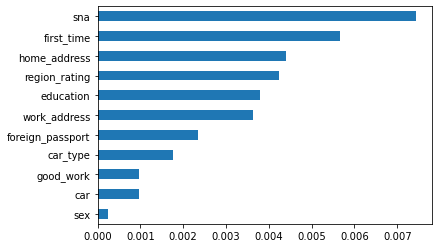

In [203]:
imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Признаки `sex`, `car`,`good_work` являются наименее важными

In [204]:
cat_cols.append("days")
# Стандартизация числовых переменных c RobustScaler, так как остались выбросы
X_num_train = RobustScaler().fit_transform(df_train[num_cols].values)
# Объединяем
X = np.hstack([X_num_train, df_train[bin_cols + cat_cols].values, X_cat])
Y = df_train['default'].values

In [205]:
X_num_test = RobustScaler().fit_transform(df_test[num_cols].values)
X_test = np.hstack([X_num_test, df_test[bin_cols + cat_cols].values, X_cat_test])

Удалим наименее значимые признаки `sex` и `age`

In [206]:
df_train.drop(['sex', 'age'], axis='columns', inplace=True)
df_train

,client_id,app_date,education,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,3,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798127,4,1,0,0,31
1,63161,2014-03-12,3,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852194,4,1,0,0,70
2,25887,2014-02-01,3,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308953,1,4,1,0,31
3,16222,2014-01-23,3,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210340,1,3,0,0,22
4,101655,2014-04-18,1,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308953,1,4,1,0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,1,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.740969,4,4,0,0,62
73795,76821,2014-03-24,3,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156251,1,4,0,0,82
73796,103695,2014-04-22,3,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714418,2,2,0,0,111
73797,861,2014-01-04,3,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472705,2,3,0,1,3


## Построение модели

In [207]:
# Разделим данные для проверки модели

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_seed)

In [208]:
# Создаём модель
model = LogisticRegression()

# Обучаем модель на тестовом наборе данных
model.fit(x_train,y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
probs = model.predict_proba(x_test)
probs = probs[:,1]

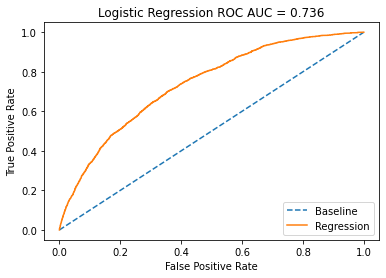

In [209]:
# Сравниваем предсказанные значения (probs) с реальными (y_test)
fpr, tpr, threshold = roc_curve(y_test, probs)

roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Подбор гиперпараметров

In [210]:
%%time
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

multi_class = ['auto', 'ovr', 'multinomial']
max_iter = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
class_weight = ['balanced', None]

# Создадим гиперпараметры
#hyperparameters = dict(C=C, penalty=penalty, multi_class=multi_class, max_iter=max_iter)
hyperparameters = dict(C=C, penalty=penalty, multi_class=multi_class)

model = LogisticRegression(random_state=random_seed)
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# Показать лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее multi_class:', best_model.best_estimator_.get_params()['multi_class'])
#print('Лучшее class_weight:', best_model.best_estimator_.get_params()['class_weight'])

#print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter'])
best_model.best_estimator_.get_params()

Лучшее Penalty: l2
Лучшее C: 3593.813663804626
Лучшее multi_class: auto
CPU times: user 4min 37s, sys: 3.12 s, total: 4min 41s
Wall time: 2min 20s


{'C': 3593.813663804626,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 31,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Модель с подобранными гиперпараметрами

In [220]:
model = LogisticRegression(penalty=best_model.best_estimator_.get_params()['penalty'], 
                           C=best_model.best_estimator_.get_params()['C'], 
                           max_iter=100, 
                           solver="sag",
                           multi_class=best_model.best_estimator_.get_params()['multi_class'], 
                           class_weight="balanced", 
                           random_state=random_seed)
model.fit(X, Y)

probs = model.predict(X_test)

In [222]:
submission = pd.DataFrame()
submission['client_id'] = df_test['client_id']
submission['default'] = probs
submission.to_csv('submission15.csv', index=False)
submission

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
...,...,...
36344,83775,1
36345,106254,0
36346,81852,1
36347,1971,1
